# Análise dos preços de apartamentos em Salvador

A análise será feita com os dados extraídos na OLX em 05/02/2023.

## Extração dos dados no site da OLX

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
from bs4 import BeautifulSoup
import time
from tqdm import tqdm

headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'accept-language':'pt-BR,pt;q=0.6',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding':'gzip, deflate'
}


### Web Scraping

In [2]:
#Função para pegar os dados de cada anúncio:
def scrape_olx_item(item):
    #Título do anuncio:
    titulo = item.select("a > div.sc-fgfRvd.fZoIzL > div.sc-hIVACf.dUnJVd > div.sc-gpHHfC.kJrkKt > h2")
    titulo_anuncio = titulo[0].text

    #Tipo de imóvel:
    tp_imovel_item = item.select("h3")
    tp_imovel_item = [x for x in tp_imovel_item if "venda" in x.text]
    tp_imovel = tp_imovel_item[0].text

    #Informações que não existem em todos os anuncios
    quarto_info, area_info, garagem_info, banheiro_info, iptu_info, condominio_info = '','','','','',''

    #Informações de banheiro, area, quartos e garagem:
    for i in range(1,8):
        try:
            atributo = item.select(f"ul > li:nth-child({i}) > span")[0].attrs['aria-label']
            if 'QUARTO' in atributo.upper():
                quarto_info = atributo
            elif 'METRO' in atributo.upper():
                area_info = atributo
            elif 'GARAGEM' in atributo.upper():
                garagem_info = atributo
            elif 'BANHEIRO' in atributo.upper():
                banheiro_info = atributo 
        except:
            pass

    #Dados de localização:
    localizacao_item = item.select('a > div.sc-fgfRvd.fZoIzL > div.sc-kQsIoO.kbWREw > div > div.sc-hjRWVT.lgwjMd > span:nth-child(2)')[0]
    cidade, bairro = [x.strip() for x in localizacao_item.text.split(',')]

    #Valores:
    preco_item = item.select('a > div.sc-fgfRvd.fZoIzL > div.sc-hIVACf.dUnJVd > div.sc-cpmKsF.ecSOri > span.main-price')
    preco_imovel = preco_item[0].text

    #Condomínio e IPTU:
    for i in range(1,4):
        try:
            valor_atributo = item.select(f'a > div.sc-fgfRvd.fZoIzL > div.sc-hIVACf.dUnJVd > div.sc-cpmKsF.ecSOri > span:nth-child({i})')[0].text
            if 'IPTU' in valor_atributo.upper():
                iptu_info = valor_atributo
            elif 'CONDOM' in valor_atributo.upper():
                condominio_info = valor_atributo
        except:
            pass

    #Link do anúncio:
    link_anuncio = item.select('a')[0].attrs['href']
    id_anuncio = link_anuncio.split('-')[-1]


    #Data do anúncio:
    data_anuncio_info = item.select('a > div.sc-fgfRvd.fZoIzL > div.sc-kQsIoO.kbWREw > div > div.sc-hjRWVT.lgwjMd > span:nth-child(4)')[0].text

    #Talvez pegar o CEP dentro de cada pagina depois
    return titulo_anuncio, tp_imovel, quarto_info, area_info, garagem_info, banheiro_info, cidade, bairro, preco_imovel, iptu_info, condominio_info, link_anuncio, data_anuncio_info, id_anuncio


#Função para converter quantitativos para string:
def string_to_float_olx(string):
    try:
        return float(string.split()[0])
    except (ValueError, IndexError) as e:
            try:
                return float(string.split()[-1])
            except (ValueError, IndexError) as e:
                return np.nan

#Função para converter a data do anúncio:
def olx_date_to_datetime(date_string):
    if 'HOJE' in date_string.upper():
        date_anuncio = dt.datetime.now()
        return dt.datetime(date_anuncio.year, date_anuncio.month, date_anuncio.day, int(date_string.split(', ')[1].split(':')[0]), int(date_string.split(', ')[1].split(':')[1]))
    elif 'ONTEM' in date_string.upper():
        date_anuncio = dt.datetime.now() + dt.timedelta(days=-1)
        return dt.datetime(date_anuncio.year, date_anuncio.month, date_anuncio.day, int(date_string.split(', ')[1].split(':')[0]), int(date_string.split(', ')[1].split(':')[1])) 
    try:
        hoje = dt.datetime.now()
        day_month, hour_min = date_string.split(', ')
        month_map = {"jan": 1,"fev": 2,"mar": 3,"abr": 4,"mai": 5,"jun": 6,"jul": 7,"ago": 8,"set": 9,"out": 10,"nov": 11,"dez": 12}
        mes = month_map[day_month.split()[-1].lower()]
        dia = int(day_month.split()[0])
        hora, minuto = map(int, hour_min.split(":"))
        candidate_date = dt.datetime(hoje.year, mes, dia, hora, minuto)

        if candidate_date > hoje:
            ano = hoje.year - 1
        else:
            ano = hoje.year
        return dt.datetime(ano, mes, dia, hora, minuto)
    except (ValueError, KeyError):
        return None


In [3]:
for page_olx in tqdm(range(1,131)):
    time.sleep(1)
    URL = f"https://www.olx.com.br/imoveis/venda/apartamentos/estado-ba/grande-salvador/salvador?o={page_olx}"

    response = requests.get(url=URL,headers=headers)
    salvador_olx_data = response.text
    soup = BeautifulSoup(salvador_olx_data, "html.parser")

    page_data_items = soup.select("#ad-list > li")

    for item in page_data_items:
        if not item.attrs['class'][0] == 'sponsored':
            try:
                #Pegar dados de cada item:
                titulo_anuncio, tp_imovel, quarto_info, area_info, garagem_info, banheiro_info, cidade, bairro, preco_imovel, iptu_info, condominio_info, link_anuncio, data_anuncio_info, id_anuncio = scrape_olx_item(item)

                #Converter dados quantitativos para foat:
                qtd_quartos = string_to_float_olx(quarto_info)
                area_m2 = string_to_float_olx(area_info)
                vagas_garagem = string_to_float_olx(garagem_info)
                qtd_banheiros = string_to_float_olx(banheiro_info)
                valor_imovel = string_to_float_olx(preco_imovel.replace('.',''))
                valor_iptu = string_to_float_olx(iptu_info.replace('.',''))
                valor_condominio = string_to_float_olx(condominio_info.replace('.',''))

                #Converter data do anúncio para data:
                data_anuncio_datetime = olx_date_to_datetime(data_anuncio_info).strftime('%Y-%m-%d %H:%M')

                #Criação do Dataframe:
                anuncio_dict = {
                    'ID_ANUNCIO': id_anuncio,
                    'TIPO_IMOVEL': tp_imovel.split()[0],
                    'TITULO': titulo_anuncio,
                    'QUARTO_INFOS': quarto_info,
                    'QTD_QUARTOS': qtd_quartos,
                    'AREA_M2': area_m2,
                    'GARAGEM_INFOS': garagem_info,
                    'VAGAS_GARAGEM': vagas_garagem,
                    'BANHEIROS_INFOS': banheiro_info,
                    'QTD_BANHEIROS': qtd_banheiros,
                    'CIDADE': cidade,
                    'BAIRRO': bairro,
                    'VALOR_RS': valor_imovel,
                    'IPTU_RS': valor_iptu,
                    'CONDOMINIO_RS': valor_condominio,
                    'DATA_PUBLICACAO': data_anuncio_datetime,
                    'LINK': link_anuncio,
                }

                df_anuncio_id = pd.DataFrame(data=anuncio_dict.items()).T
                df_anuncio_id.columns = df_anuncio_id.iloc[0]
                df_anuncio_id = df_anuncio_id[1:]

                #Agrupar anuncios em data frame TT:
                try:
                    df_anuncios_tt = pd.concat([df_anuncios_tt, df_anuncio_id])
                except:
                    df_anuncios_tt = df_anuncio_id
            except IndexError:
                pass

100%|██████████| 130/130 [06:16<00:00,  2.90s/it]


In [4]:
df_anuncios_tt.reset_index(inplace=True)
df_anuncios_tt.drop_duplicates(inplace=True)
df_anuncios_tt = df_anuncios_tt[list(anuncio_dict.keys())]
df_anuncios_tt.head()

,ID_ANUNCIO,TIPO_IMOVEL,TITULO,QUARTO_INFOS,QTD_QUARTOS,AREA_M2,GARAGEM_INFOS,VAGAS_GARAGEM,BANHEIROS_INFOS,QTD_BANHEIROS,CIDADE,BAIRRO,VALOR_RS,IPTU_RS,CONDOMINIO_RS,DATA_PUBLICACAO,LINK
0,1032509023,Apartamento,SALVADOR - Apartamento Padrão - GRAÇA,4 quartos,4.0,305.0,3 vagas de garagem,3.0,5 ou mais banheiros,5.0,Salvador,Graça,4800000.0,2000.0,1900.0,2023-02-05 18:34,https://ba.olx.com.br/grande-salvador/imoveis/...
1,1093674215,Apartamento,Apartamento na Graça com 4 quartos com suíte ...,4 quartos,4.0,180.0,2 vagas de garagem,2.0,3 banheiros,3.0,Salvador,Graça,550000.0,140.0,1245.0,2023-02-05 18:34,https://ba.olx.com.br/grande-salvador/imoveis/...
2,1036623948,Apartamento,Apartamento residencial para Venda RUA DO JABO...,1 quarto,1.0,56.0,1 vaga de garagem,1.0,1 banheiro,1.0,Salvador,Caminho das Árvores,459000.0,NaN,450.0,2023-02-05 18:34,https://ba.olx.com.br/grande-salvador/imoveis/...
3,984020770,Apartamento,Salvador - Kitchenette/Conjugados - Pituba,1 quarto,1.0,71.0,1 vaga de garagem,1.0,1 banheiro,1.0,Salvador,Pituba,225000.0,68.0,313.0,2023-02-05 18:32,https://ba.olx.com.br/grande-salvador/imoveis/...
4,933913019,Apartamento,Apartamento para venda com 260 metros quadrado...,4 quartos,4.0,260.0,4 vagas de garagem,4.0,5 ou mais banheiros,5.0,Salvador,Horto Florestal,2000000.0,638.0,2200.0,2023-02-05 18:32,https://ba.olx.com.br/grande-salvador/imoveis/...


In [5]:
df_anuncios_tt.describe()

,ID_ANUNCIO,TIPO_IMOVEL,TITULO,QUARTO_INFOS,QTD_QUARTOS,AREA_M2,GARAGEM_INFOS,VAGAS_GARAGEM,BANHEIROS_INFOS,QTD_BANHEIROS,CIDADE,BAIRRO,VALOR_RS,IPTU_RS,CONDOMINIO_RS,DATA_PUBLICACAO,LINK
count,4958,4958,4958,4958,4958.0,4943.0,4958,4518.0,4958,4958.0,4958,4958,4958.0,3719.0,3675.0,4958,4958
unique,4958,1,4437,5,5.0,356.0,6,5.0,5,5.0,1,121,999.0,996.0,815.0,1516,4958
top,1032509023,Apartamento,Apartamento para Venda em Salvador/BA,3 quartos,3.0,80.0,1 vaga de garagem,1.0,2 banheiros,2.0,Salvador,Pituba,450000.0,1.0,800.0,2023-02-05 13:43,https://ba.olx.com.br/grande-salvador/imoveis/...
freq,1,4958,23,1881,1881.0,151.0,2065,2065.0,1294,1294.0,4958,749,111.0,67.0,98.0,48,1


In [8]:
df_anuncios_tt.to_csv('./dados_apartamentos_olx.csv', sep=';')

## Data Analysis

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
df_anuncios = pd.read_csv('./dados_apartamentos_olx.csv', sep=';', index_col = 0)

df_anuncios['AREA_SEGMENTADA'] = pd.qcut(df_anuncios['AREA_M2'], q=5)

variaveis_categoricas = ['TIPO_IMOVEL', 'QUARTO_INFOS', 'GARAGEM_INFOS', 'BANHEIROS_INFOS','QTD_BANHEIROS', 'AREA_SEGMENTADA', 'CIDADE', 'BAIRRO']
variaveis_quantitativas = ['QTD_QUARTOS','AREA_M2', 'VAGAS_GARAGEM', 'QTD_BANHEIROS', 'VALOR_RS', 'IPTU_RS', 'CONDOMINIO_RS', 'DATA_PUBLICACAO']
variaveis_identificacao = ['ID_ANUNCIO', 'TITULO', 'LINK']

print(df_anuncios.columns)
df_anuncios.head()



Index(['ID_ANUNCIO', 'TIPO_IMOVEL', 'TITULO', 'QUARTO_INFOS', 'QTD_QUARTOS',
       'AREA_M2', 'GARAGEM_INFOS', 'VAGAS_GARAGEM', 'BANHEIROS_INFOS',
       'QTD_BANHEIROS', 'CIDADE', 'BAIRRO', 'VALOR_RS', 'IPTU_RS',
       'CONDOMINIO_RS', 'DATA_PUBLICACAO', 'LINK', 'AREA_SEGMENTADA'],
      dtype='object')


,ID_ANUNCIO,TIPO_IMOVEL,TITULO,QUARTO_INFOS,QTD_QUARTOS,AREA_M2,GARAGEM_INFOS,VAGAS_GARAGEM,BANHEIROS_INFOS,QTD_BANHEIROS,CIDADE,BAIRRO,VALOR_RS,IPTU_RS,CONDOMINIO_RS,DATA_PUBLICACAO,LINK,AREA_SEGMENTADA
0,1032509023,Apartamento,SALVADOR - Apartamento Padrão - GRAÇA,4 quartos,4.0,305.0,3 vagas de garagem,3.0,5 ou mais banheiros,5.0,Salvador,Graça,4800000.0,2000.0,1900.0,2023-02-05 18:34,https://ba.olx.com.br/grande-salvador/imoveis/...,"(163.0, 4126.0]"
1,1093674215,Apartamento,Apartamento na Graça com 4 quartos com suíte ...,4 quartos,4.0,180.0,2 vagas de garagem,2.0,3 banheiros,3.0,Salvador,Graça,550000.0,140.0,1245.0,2023-02-05 18:34,https://ba.olx.com.br/grande-salvador/imoveis/...,"(163.0, 4126.0]"
2,1036623948,Apartamento,Apartamento residencial para Venda RUA DO JABO...,1 quarto,1.0,56.0,1 vaga de garagem,1.0,1 banheiro,1.0,Salvador,Caminho das Árvores,459000.0,NaN,450.0,2023-02-05 18:34,https://ba.olx.com.br/grande-salvador/imoveis/...,"(12.999, 60.0]"
3,984020770,Apartamento,Salvador - Kitchenette/Conjugados - Pituba,1 quarto,1.0,71.0,1 vaga de garagem,1.0,1 banheiro,1.0,Salvador,Pituba,225000.0,68.0,313.0,2023-02-05 18:32,https://ba.olx.com.br/grande-salvador/imoveis/...,"(60.0, 80.0]"
4,933913019,Apartamento,Apartamento para venda com 260 metros quadrado...,4 quartos,4.0,260.0,4 vagas de garagem,4.0,5 ou mais banheiros,5.0,Salvador,Horto Florestal,2000000.0,638.0,2200.0,2023-02-05 18:32,https://ba.olx.com.br/grande-salvador/imoveis/...,"(163.0, 4126.0]"


In [ ]:
#Checagem de dados nulos
df_anuncios.isnull().sum()

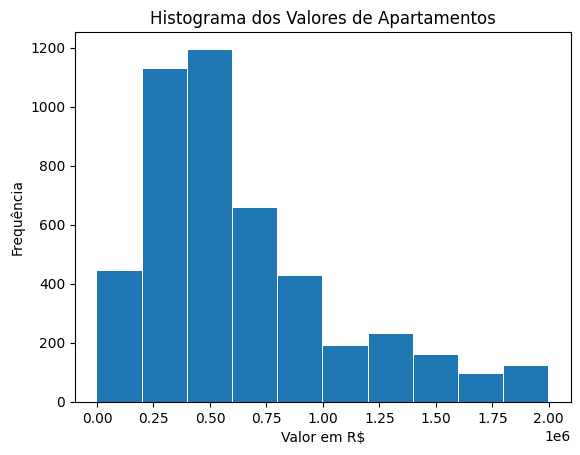

In [58]:

df_anuncios['VALOR_RS'].plot(kind='hist', bins=10, rwidth=0.98, range=(0,2000000))

# Add labels and title to the plot
plt.xlabel('Valor em R$')
plt.ylabel('Frequência')
plt.title('Histograma dos Valores de Apartamentos')

# Show the plot
plt.show()

In [152]:
df_anuncios.groupby(['BAIRRO']).median()["VALOR_RS"]

BAIRRO
Acupe de Brotas         293500.0
Alphaville I           1050000.0
Alto do Coqueirinho     250000.0
Amaralina               270000.0
Areia Branca            141966.5
                         ...    
Vila Canária            139999.0
Vila Laura              380000.0
Vila Ruy Barbosa        148000.0
Vitória                1600000.0
Águas Claras             60000.0
Name: VALOR_RS, Length: 121, dtype: float64

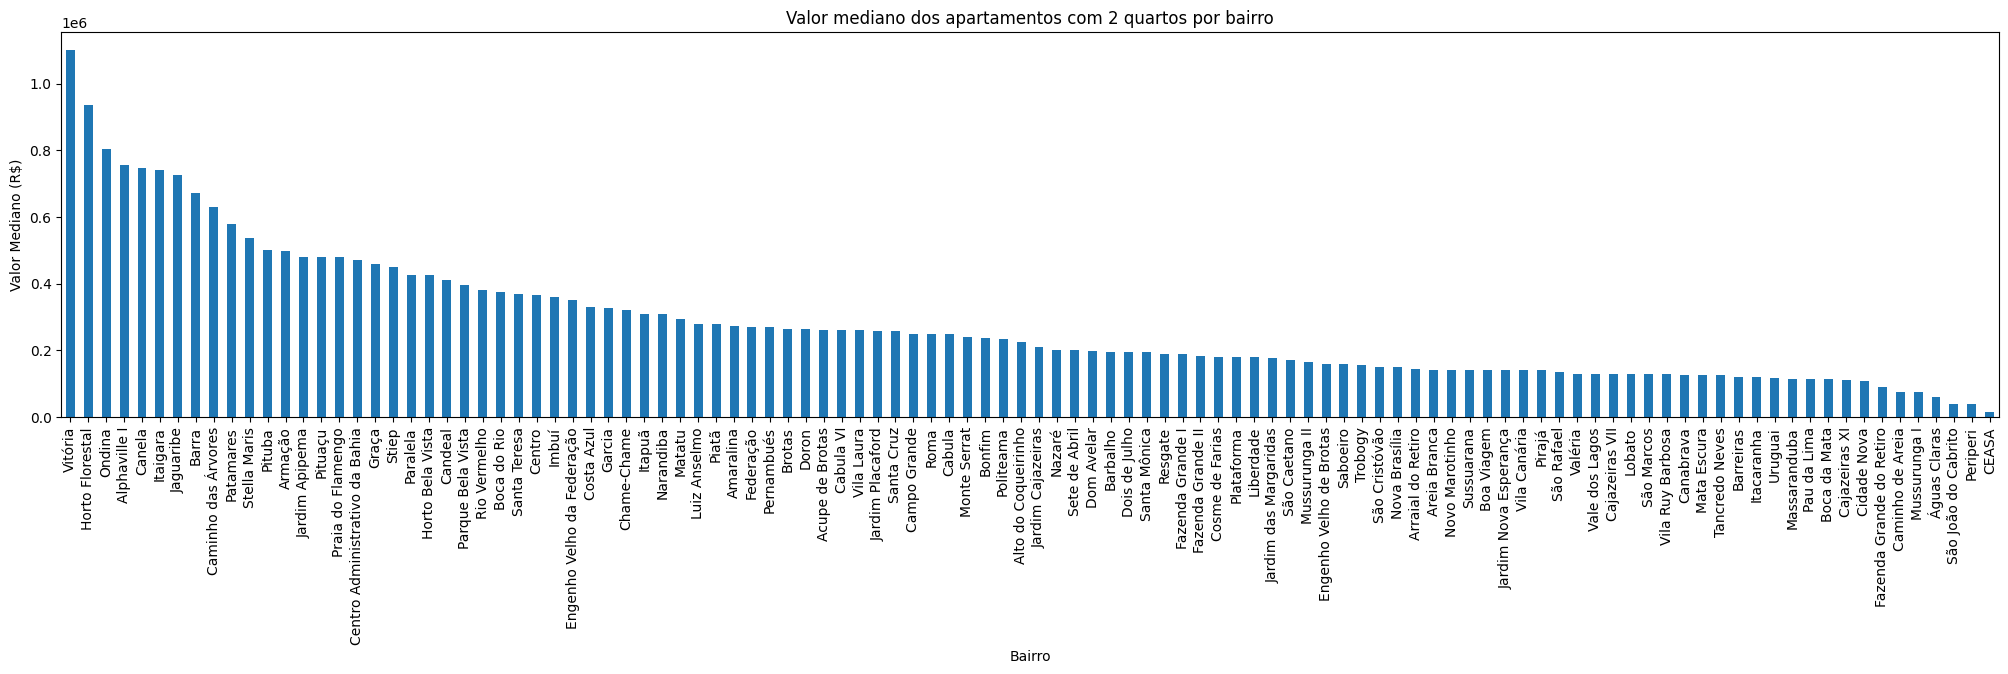

In [164]:
#Valores agrupados por bairro
fig, ax = plt.subplots(figsize=(25, 5))
df_anuncios[df_anuncios['QTD_QUARTOS']==2].groupby(['BAIRRO']).median()["VALOR_RS"].sort_values(ascending=False).plot(kind="bar")
#df_anuncios.groupby(['BAIRRO']).mean()["VALOR_RS"].plot(kind="line", color="blue")  
#media_bairros = df_anuncios.groupby(['BAIRRO']).mean().reset_index()

ax.set_xlabel('Bairro')
ax.set_ylabel('Valor Mediano (R$)')
ax.set_title('Valor mediano dos apartamentos com 2 quartos por bairro')

plt.xticks(rotation=90)

plt.show()

<AxesSubplot:xlabel='AREA_M2', ylabel='VALOR_RS'>

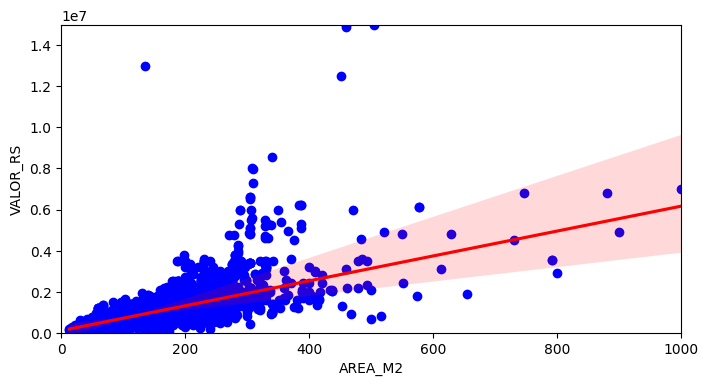

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

ax.scatter(df_anuncios['AREA_M2'], df_anuncios['VALOR_RS'], color='blue')
ax.set_xlabel('Área')
ax.set_ylabel('Valor em R$')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 15000000)
ax.set_title('')
sns.regplot(data=df_anuncios, x='AREA_M2', y='VALOR_RS', ax=ax, color='red', scatter=False)


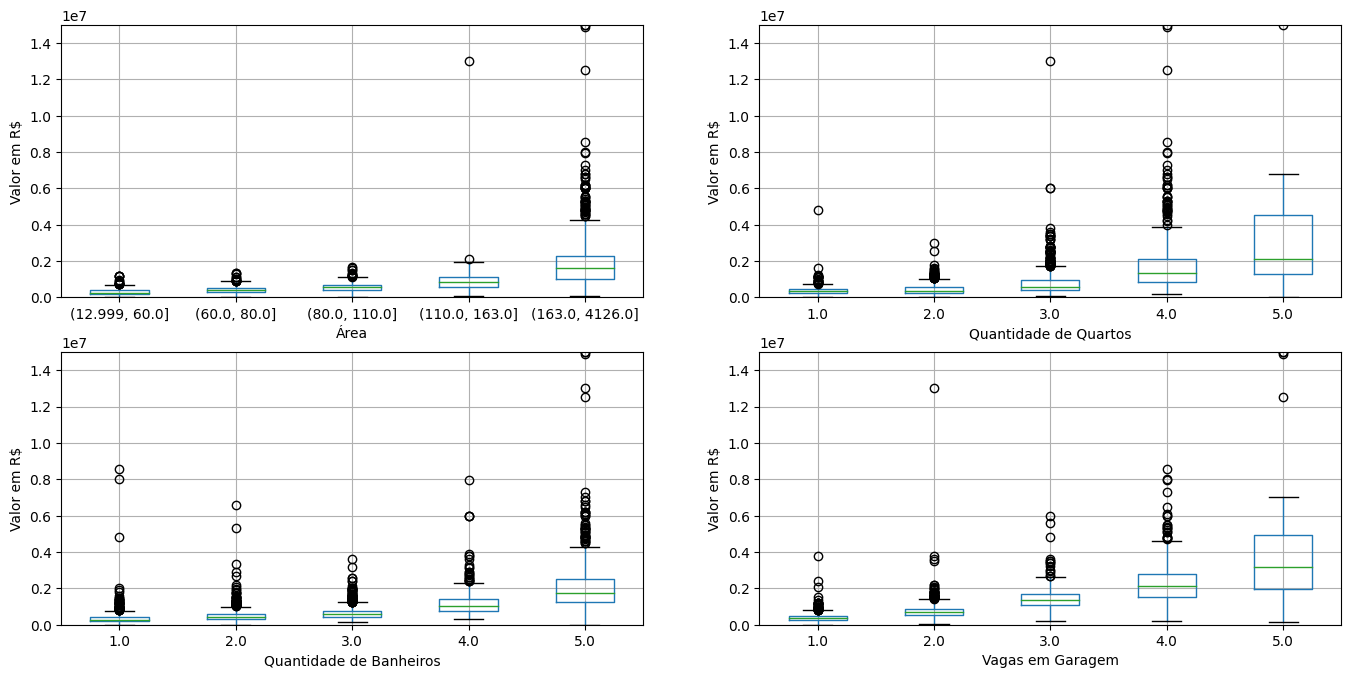

In [129]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

df_anuncios.boxplot(column='VALOR_RS', by='AREA_SEGMENTADA', ax=axs[0,0])
df_anuncios.boxplot(column='VALOR_RS', by='QTD_QUARTOS', ax=axs[0,1])
df_anuncios.boxplot(column='VALOR_RS', by='QTD_BANHEIROS', ax=axs[1,0])
df_anuncios.boxplot(column='VALOR_RS', by='VAGAS_GARAGEM', ax=axs[1,1])

axs[0,0].set_xlabel('Área')
axs[0,0].set_ylabel('Valor em R$')
axs[0,0].set_ylim(0, 15000000)
axs[0,0].set_title('')
#sns.regplot(data=df_anuncios, x='AREA_M2', y='VALOR_RS', ax=axs[0,0], color='red')

axs[0,1].set_xlabel('Quantidade de Quartos')
axs[0,1].set_ylabel('Valor em R$')
axs[0,1].set_ylim(0, 15000000)
axs[0,1].set_title('')

axs[1,0].set_xlabel('Quantidade de Banheiros')
axs[1,0].set_ylabel('Valor em R$')
axs[1,0].set_ylim(0, 15000000)
axs[1,0].set_title('')

axs[1,1].set_xlabel('Vagas em Garagem')
axs[1,1].set_ylabel('Valor em R$')
axs[1,1].set_ylim(0, 15000000)
axs[1,1].set_title('')

fig.suptitle('')
plt.show()

### Análise de Correspondência Múltipla